In [1]:
#loading the dataset
import os
from os import listdir
import numpy as np
from numpy import asarray
from numpy import vstack
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from numpy import savez_compressed
#load and plot the prepared dataset
from numpy import load
from matplotlib import pyplot

In [2]:

#the photos are of sqaure size 256*256
#we create an array of images for Category A and another for Category B. Both the arrays are then saved to a new file in compressed Numpy array format.

#loading all the images in a directory into memory.
def load_images(path, size=(256,256)):
    data_list = list()
    #list all the names of the files within the directory(enumerate)
    for filename in listdir(path):
        #load and resize the image
        pixels = load_img(path+filename, target_size=size)
        #now convert to numpy array
        pixels = img_to_array(pixels)
        #store to memory
        data_list.append(pixels)
        return asarray(data_list)
path = '/kaggle/input/cyclegan/vangogh2photo/vangogh2photo/'
#load Dataset A
dataA1 = load_images(path + 'trainA/')
dataA2 = load_images(path +'testA/')
dataA = vstack((dataA1,dataA2))
print('Dataset A loaded', dataA.shape)
#load Dataset B
dataB1 = load_images(path + 'trainB/')
dataB2 = load_images(path +'testB/')
dataB = vstack((dataB1,dataB2))
print('Dataset A loaded', dataB.shape)
#save as compressed numpy array
filename = 'vangogh2photo_comp.npz'
savez_compressed(filename, dataA,dataB)
print('Saved Dataset:', filename)
#the size is larger than the raw images as we are storing pixel values as 32-bit floating point values.




Dataset A loaded (2, 256, 256, 3)
Dataset A loaded (2, 256, 256, 3)
Saved Dataset: vangogh2photo_comp.npz


Loaded:  (2, 256, 256, 3) (2, 256, 256, 3)


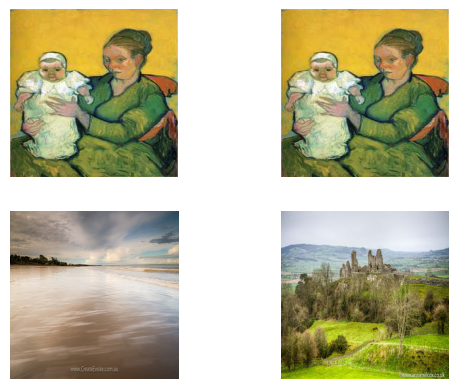

In [3]:
data = load('vangogh2photo_comp.npz')
dataA, dataB = data['arr_0'], data['arr_1']
print('Loaded: ', dataA.shape, dataB.shape)
# plot source images
n_samples = 2
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(dataA[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(dataB[i].astype('uint8'))
pyplot.show()

# 2. Develop a Generative Model
### we have to create 4 models: 2 discriminator models, 2 generator models
*  the discriminator is a deep CNN network that performs image classification. It takes a source image as input and predicts the likelihood of whether the target image is real or fake.
* Discriminator design is based on the effective receptive field of the model which defines the relationship between one output of the model to the number of pixels in the input image.This is called a PatchGAN model and is carefully designed so that each output prediction of the model maps 70X70 squares or patch of the input image.The benefit of this is that it, this model can be applied to input images of different sizes, i.e that is larger or smaller than 256X256 pixels
* Unlike other models, the cycleGAN discriminator uses InstanceNormalisation instead of BatchNormalization.This involves standardizing(scaling to a standard guassian) the values on each output feature map,rather than across features in the batch. This can be accessed from the *keras contrib project*

In [4]:
pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-pwpxwdld
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-pwpxwdld
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... - done
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101076 sha256=f13f6b7cd4b83d9d9126685539dd8f53683e800b0cf34dfe119779143722ca2b
  Stored in directory: /tmp/pip-ephem-wheel-cache-p5kpdqze/wheels/bb/1f/f2/b57495012683b6b20bbae94a3915ec79753111452d79886abc
Successfully built keras-contrib
Note: you may need to restart the kernel to use updated packages.


In [5]:
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
# define layer
layer = InstanceNormalization(axis=-1)
#axis = -1 to ensure that features are normalized per feature map

### This function implements the 70X70 patchGAN discriminator model. 
The model takes 256X256 sized image as input and outputs a patch of perdictions.
the model is optimized using least square loss (implemented as mean squared error), and a weighting is used so that the updates if the model have half (0.5)
the usual effect.(this was reccomended by the authors of the paper to slow down the changes to the discriminator relative to the generator 
                 model during training)

In [6]:
def define_discriminator(image_shape):
    #weight initialization
    init = RandomNormal(stddev=0.02)
    #source image input
    in_image = Input(shape=image_shape)
    #64
    d = Conv2D(64,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(in_image)
    d = LeakyReLU(alpha=0.2)(d)
    #128
    d = Conv2D(128,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    #256
    d = Conv2D(256,(4,4),strides=(2,2),padding='same',kernel_initalizer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyRelu(alpha=0.2)(d)
    #512
    d = Conv2D(512,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(d)
    d =InstanceNormalization(axis=-1)(d)
    d = LeakyRelu(alpha=0.2)(d)
    #prefinal output layer
    d = Conv2D(512,(4,4),padding='same',kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyRelu(alpha=0.2)(d)
    #patch output
    patch_out = Conv2D(1,(4,4),padding='same',kernel_initializer=init)(d)
    #definig the model
    model = Model(in_image,patch_out)
    #compiling the model
    model.compile(loss = 'mse',optimizer = Adam(lr=0.0002,beta_1=0.5),loss_weights=[0.5])
    return model